# Dark Trace AI — Training Notebook

This notebook performs quick EDA, builds lexicon-augmented features, trains a baseline suspicious-content classifier, saves artifacts, and runs inference examples.



In [ ]:
# Setup: imports and paths
import os
import re
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

DATA_DIR = Path('.')
ARTIFACTS_DIR = DATA_DIR / 'artifacts'
ARTIFACTS_DIR.mkdir(exist_ok=True)

EMOJI_DICT_PATH = DATA_DIR / 'drug_emoji_dictionary.csv'
SLANG_DICT_PATH = DATA_DIR / 'drug_slang_dictionary.csv'
CONV_PATH = DATA_DIR / 'synthetic_drug_conversations.csv'
EMOJI_DS_PATH = DATA_DIR / 'synthetic_emoji_dataset.csv'
SLANG_DS_PATH = DATA_DIR / 'synthetic_slang_dataset.csv'

pd.set_option('display.max_colwidth', 200)
print('Paths ready.', DATA_DIR.resolve())


Paths ready. D:\Codes\Dark Trace AI\darktrace-ai-


In [3]:
# Load dictionaries and datasets
emoji_dict = pd.read_csv(EMOJI_DICT_PATH)
slang_dict = pd.read_csv(SLANG_DICT_PATH)
conv = pd.read_csv(CONV_PATH)
emoji_ds = pd.read_csv(EMOJI_DS_PATH)
slang_ds = pd.read_csv(SLANG_DS_PATH)

print('Emoji dict', emoji_dict.shape)
print('Slang dict', slang_dict.shape)
print('Conversations', conv.shape)
print('Emoji ds', emoji_ds.shape)
print('Slang ds', slang_ds.shape)

emoji_dict.head(), slang_dict.head(), conv.head()[:3]


Emoji dict (200, 3)
Slang dict (200, 3)
Conversations (30024, 12)
Emoji ds (10000, 7)
Slang ds (10000, 7)


(  emoji                 meaning drug_category
 0     🍁  All drugs (maple leaf)     universal
 1     💊        Pills/medication     universal
 2     💉        Injection/heroin     universal
 3     🔥       High quality/fire     universal
 4     💨          Smoking/vaping     universal,
   slang_term  drug_type                definition
 0       weed  marijuana  Cannabis plant/marijuana
 1       herb  marijuana             Cannabis herb
 2      grass  marijuana       Slang for marijuana
 3        pot  marijuana     Common marijuana term
 4       dope  marijuana     Street marijuana name,
    message_id  conversation_id  platform sender_id recipient_id  \
 0           1                1  whatsapp      1888         1666   
 1           2                1  whatsapp      1888         1666   
 2           3                1  whatsapp      1888         1666   
 
             message_text       timestamp  message_type  contains_slang  \
 0  looking for some work  7/9/2025 10:39       inquiry      

In [4]:
# Enhanced Feature Extractor with additional features
class EnhancedFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, text_col='message_text'):
        self.text_col = text_col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.Series):
            texts = X
        else:
            texts = X[self.text_col]
            
        n_samples = len(texts)
        
        # Initialize feature arrays
        emoji_features = np.zeros((n_samples, 3))  # total, unique, suspicious combos
        context_features = np.zeros((n_samples, 5))  # urgent time, late hours, location, quantity, price
        behavioral_features = np.zeros((n_samples, 4))  # urgency, discretion, quality, transaction
        slang_features = np.zeros((n_samples, 3))  # total, unique, proximity
        
        for i, text in enumerate(texts):
            # Emoji patterns
            emojis = re.findall(r'[\U0001F300-\U0001F9FF]', text)
            emoji_features[i, 0] = len(emojis)  # total emojis
            emoji_features[i, 1] = len(set(emojis))  # unique emojis
            
            # Suspicious emoji combinations (drug-related emojis appearing together)
            drug_emojis = {'🍁', '💊', '💉', '🔥', '💨', '🌿', '🌱', '🪴', '🍄'}
            suspicious_combo = sum(1 for e in emojis if e in drug_emojis)
            emoji_features[i, 2] = suspicious_combo > 1
            
            # Context patterns
            text_lower = text.lower()
            
            # Time patterns
            urgent_time = bool(re.search(r'(asap|quick|fast|rush|hurry|now)', text_lower))
            late_hours = bool(re.search(r'(midnight|late|night|after hours|pm)', text_lower))
            
            # Location patterns
            discrete_location = bool(re.search(r'(spot|location|place|meet|behind|alley)', text_lower))
            
            # Quantity/Price patterns
            precise_quantity = bool(re.search(r'(\d+\s*(g|gram|oz|ounce|lb|pound|k|kilo))', text_lower))
            price_negotiation = bool(re.search(r'(\$\d+|\d+\s*dollars|price|cost|deal)', text_lower))
            
            context_features[i] = [urgent_time, late_hours, discrete_location, precise_quantity, price_negotiation]
            
            # Behavioral patterns
            urgency = bool(re.search(r'(need|want|looking|asap|urgent|today)', text_lower))
            discretion = bool(re.search(r'(quiet|private|secret|discrete|careful|safe)', text_lower))
            quality = bool(re.search(r'(good|pure|clean|best|quality|fire)', text_lower))
            transaction = bool(re.search(r'(have|got|available|supply|plug|connect)', text_lower))
            
            behavioral_features[i] = [urgency, discretion, quality, transaction]
            
            # Slang patterns
            slang_words = set(w.lower() for w in slang_dict['slang_term'])
            text_words = set(text_lower.split())
            total_slang = sum(1 for w in text_words if w in slang_words)
            unique_slang = len(text_words.intersection(slang_words))
            
            # Slang proximity (slang words appearing close together)
            words = text_lower.split()
            slang_positions = [i for i, w in enumerate(words) if w in slang_words]
            slang_proximity = 0
            if len(slang_positions) > 1:
                slang_proximity = any(slang_positions[i+1] - slang_positions[i] <= 3 
                                   for i in range(len(slang_positions)-1))
            
            slang_features[i] = [total_slang, unique_slang, slang_proximity]
        
        # Additional numeric features
        msg_lengths = texts.str.len()
        word_counts = texts.str.split().str.len()
        avg_word_length = texts.apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)
        
        # Punctuation features
        question_marks = texts.str.count(r'\?')
        exclamation_marks = texts.str.count(r'!')
        
        # Combine all features
        return np.column_stack([
            emoji_features,  # 3 features
            context_features,  # 5 features
            behavioral_features,  # 4 features
            slang_features,  # 3 features
            msg_lengths,  # 1 feature
            word_counts,  # 1 feature
            avg_word_length,  # 1 feature
            question_marks,  # 1 feature
            exclamation_marks  # 1 feature
        ])

# Create features for training data
train_df = conv.copy()
train_df['label_bin'] = (train_df['risk_level'].isin(['high', 'medium'])).astype(int)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    train_df, train_df['label_bin'], 
    test_size=0.2, random_state=42, 
    stratify=train_df['label_bin']
)

# Generate enhanced features
enhanced_features = EnhancedFeatureExtractor('message_text').transform(train_df)
train_df['enhanced_features'] = list(enhanced_features)

feature_names = [
    # Emoji features
    'total_emojis', 'unique_emojis', 'suspicious_emoji_combos',
    # Context features
    'urgent_time', 'late_hours', 'discrete_location', 'precise_quantity', 'price_negotiation',
    # Behavioral features
    'urgency_tactics', 'discretion_terms', 'quality_terms', 'transaction_terms',
    # Slang features
    'total_slang', 'unique_slang', 'slang_proximity',
    # Basic features
    'msg_length', 'word_count', 'avg_word_length', 'question_marks', 'exclamation_marks'
]

print("Enhanced Feature Engineering Summary:")
print(f"Total number of features: {len(feature_names)}")
print("\nFeature List:")
for i, name in enumerate(feature_names, 1):
    print(f"{i:2d}. {name}")

Enhanced Feature Engineering Summary:
Total number of features: 20

Feature List:
 1. total_emojis
 2. unique_emojis
 3. suspicious_emoji_combos
 4. urgent_time
 5. late_hours
 6. discrete_location
 7. precise_quantity
 8. price_negotiation
 9. urgency_tactics
10. discretion_terms
11. quality_terms
12. transaction_terms
13. total_slang
14. unique_slang
15. slang_proximity
16. msg_length
17. word_count
18. avg_word_length
19. question_marks
20. exclamation_marks


In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Scale features
scaler = StandardScaler()
X_enhanced_scaled = scaler.fit_transform(np.vstack(train_df['enhanced_features'].values))

# Split into train/validation
X_train_enhanced = X_enhanced_scaled[:-len(X_val)]
X_val_enhanced = X_enhanced_scaled[-len(X_val):]

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_enhanced, y_train)

# Train balanced model with tuned parameters
balanced_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
balanced_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
balanced_pred = balanced_model.predict(X_val_enhanced)
balanced_proba = balanced_model.predict_proba(X_val_enhanced)[:, 1]

print("\nModel Performance after Balancing:")
print("----------------------------------")
print("\nClassification Report:")
print(classification_report(y_val, balanced_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, balanced_pred))

print("\nROC AUC Score:", roc_auc_score(y_val, balanced_proba))

# Feature importance analysis
importances = balanced_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 10 Most Important Features:")
for f in range(min(10, len(feature_names))):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Performance at different thresholds
print("\nPerformance at Different Thresholds:")
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    pred_at_threshold = (balanced_proba >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_val, pred_at_threshold))


Model Performance after Balancing:
----------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.44      0.38      1989
           1       0.68      0.58      0.62      4016

    accuracy                           0.53      6005
   macro avg       0.51      0.51      0.50      6005
weighted avg       0.56      0.53      0.54      6005


Confusion Matrix:
[[ 878 1111]
 [1701 2315]]

ROC AUC Score: 0.5039352394344192

Top 10 Most Important Features:
1. msg_length (0.400928)
2. avg_word_length (0.267069)
3. word_count (0.082408)
4. unique_slang (0.030900)
5. quality_terms (0.029644)
6. total_slang (0.027878)
7. urgent_time (0.022892)
8. total_emojis (0.020203)
9. unique_emojis (0.020187)
10. transaction_terms (0.015471)

Performance at Different Thresholds:

Threshold: 0.3
              precision    recall  f1-score   support

           0       0.28      0.00      0.00      1989
           1       0.67   

In [6]:
# Import additional required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
import re
from collections import Counter

class EnhancedFeatureExtractorV2(BaseEstimator, TransformerMixin):
    def __init__(self, text_col='message_text', n_gram_features=100):
        self.text_col = text_col
        self.n_gram_features = n_gram_features
        self.vectorizer = TfidfVectorizer(
            ngram_range=(1, 3),
            max_features=n_gram_features,
            stop_words='english'
        )
        
    def fit(self, X, y=None):
        if isinstance(X, pd.Series):
            texts = X
        else:
            texts = X[self.text_col]
        self.vectorizer.fit(texts)
        return self
    
    def transform(self, X):
        if isinstance(X, pd.Series):
            texts = X
            platforms = pd.Series(['unknown'] * len(texts))
            timestamps = pd.Series([None] * len(texts))
        else:
            texts = X[self.text_col]
            platforms = X['platform'] if 'platform' in X.columns else pd.Series(['unknown'] * len(texts))
            timestamps = X['timestamp'] if 'timestamp' in X.columns else pd.Series([None] * len(texts))
            
        n_samples = len(texts)
        
        # 1. N-gram features
        ngram_features = self.vectorizer.transform(texts).toarray()
        
        # 2. Enhanced Emoji Analysis
        emoji_features = np.zeros((n_samples, 5))  # Extended from 3 to 5
        emoji_pattern = re.compile(r'[\U0001F300-\U0001F9FF]')
        drug_emojis = {'🍁', '💊', '💉', '🔥', '💨', '🌿', '🌱', '🪴', '🍄'}
        money_emojis = {'💰', '💵', '💸', '🤑', '💲'}
        
        for i, text in enumerate(texts):
            emojis = emoji_pattern.findall(text)
            emoji_features[i, 0] = len(emojis)  # total emojis
            emoji_features[i, 1] = len(set(emojis))  # unique emojis
            
            # Suspicious combinations
            drug_emoji_count = sum(1 for e in emojis if e in drug_emojis)
            money_emoji_count = sum(1 for e in emojis if e in money_emojis)
            emoji_features[i, 2] = drug_emoji_count > 0 and money_emoji_count > 0  # drug + money combo
            
            # Emoji sequence patterns
            if len(emojis) >= 2:
                emoji_pairs = list(zip(emojis, emojis[1:]))
                suspicious_pairs = sum(1 for e1, e2 in emoji_pairs 
                                    if (e1 in drug_emojis and e2 in money_emojis) or 
                                       (e1 in money_emojis and e2 in drug_emojis))
                emoji_features[i, 3] = suspicious_pairs > 0
            
            # Emoji density (emojis per word)
            words = text.split()
            emoji_features[i, 4] = len(emojis) / len(words) if words else 0
        
        # 3. Enhanced Context Patterns
        context_features = np.zeros((n_samples, 8))  # Extended from 5 to 8
        
        for i, text in enumerate(texts):
            text_lower = text.lower()
            words = text_lower.split()
            word_pairs = list(zip(words, words[1:]))  # bigrams
            
            # Time patterns with improved detection
            time_words = {'asap', 'quick', 'fast', 'rush', 'hurry', 'now', 'tonight', 'soon'}
            time_bigrams = {'right now', 'real quick', 'hit me', 'hmu', 'dm me'}
            context_features[i, 0] = any(w in time_words for w in words) or \
                                   any(f"{w1} {w2}" in time_bigrams for w1, w2 in word_pairs)
            
            # Time of day analysis
            try:
                if timestamps[i]:
                    time = datetime.strptime(timestamps[i], '%m/%d/%Y %H:%M').hour
                    context_features[i, 1] = 22 <= time or time <= 4  # late night
            except:
                pass
            
            # Location patterns with improved detection
            location_indicators = {'spot', 'location', 'place', 'meet', 'behind', 'alley', 'corner', 'parking'}
            discreet_locations = {'back', 'behind', 'alley', 'low', 'key', 'quiet', 'private'}
            context_features[i, 2] = any(w in location_indicators for w in words)
            context_features[i, 3] = any(w in discreet_locations for w in words)
            
            # Price patterns
            price_pattern = re.compile(r'(?:(?:\$\d+(?:k)?)|(?:\d+(?:k)?\s*(?:dollars?|bucks?))|(?:\d+(?:\.\d{2})?))') 
            context_features[i, 4] = bool(price_pattern.search(text_lower))
            
            # Quantity patterns
            quantity_pattern = re.compile(r'\d+\s*(?:g|gram|oz|ounce|lb|pound|k|kilo|piece|pack)')
            context_features[i, 5] = bool(quantity_pattern.search(text_lower))
            
            # Platform-specific patterns
            platform = platforms[i].lower()
            context_features[i, 6] = platform in {'telegram', 'signal', 'wickr'}  # secure messaging apps
            
            # Message length variation
            context_features[i, 7] = len(text) / 100.0  # normalized message length
        
        # 4. Enhanced Behavioral Patterns
        behavioral_features = np.zeros((n_samples, 6))  # Extended from 4 to 6
        
        for i, text in enumerate(texts):
            text_lower = text.lower()
            words = text_lower.split()
            
            # Urgency patterns
            urgency_words = {'need', 'want', 'looking', 'asap', 'urgent', 'today', 'quick', 'fast'}
            behavioral_features[i, 0] = sum(w in urgency_words for w in words) / len(words)
            
            # Discretion patterns
            discretion_words = {'quiet', 'private', 'secret', 'discrete', 'careful', 'safe', 'clean'}
            behavioral_features[i, 1] = any(w in discretion_words for w in words)
            
            # Quality indicators
            quality_words = {'good', 'pure', 'clean', 'best', 'quality', 'fire', 'premium', 'top'}
            behavioral_features[i, 2] = any(w in quality_words for w in words)
            
            # Transaction patterns
            transaction_words = {'have', 'got', 'available', 'supply', 'plug', 'connect', 'hook'}
            behavioral_features[i, 3] = any(w in transaction_words for w in words)
            
            # Trust building
            trust_words = {'legit', 'trusted', 'reliable', 'safe', 'guaranteed', 'genuine'}
            behavioral_features[i, 4] = any(w in trust_words for w in words)
            
            # Exclusivity/Urgency
            exclusive_words = {'limited', 'exclusive', 'special', 'only', 'few', 'left'}
            behavioral_features[i, 5] = any(w in exclusive_words for w in words)
        
        # 5. Enhanced Slang Analysis
        slang_features = np.zeros((n_samples, 5))  # Extended from 3 to 5
        
        for i, text in enumerate(texts):
            text_lower = text.lower()
            words = text_lower.split()
            word_pairs = list(zip(words, words[1:]))  # bigrams
            
            # Known slang words
            slang_words = set(w.lower() for w in slang_dict['slang_term'])
            text_slang = [w for w in words if w in slang_words]
            
            slang_features[i, 0] = len(text_slang)  # total slang
            slang_features[i, 1] = len(set(text_slang))  # unique slang
            
            # Slang proximity and density
            if len(text_slang) > 1:
                word_positions = [j for j, w in enumerate(words) if w in slang_words]
                min_distance = min(word_positions[j+1] - word_positions[j] 
                                for j in range(len(word_positions)-1))
                slang_features[i, 2] = 1.0 / (1.0 + min_distance)  # normalized proximity
            
            # Slang variety (different drug categories)
            if text_slang:
                categories = set(slang_dict[slang_dict['slang_term'].str.lower().isin(text_slang)]['drug_type'])
                slang_features[i, 3] = len(categories)
            
            # Slang density
            slang_features[i, 4] = len(text_slang) / len(words) if words else 0
            
        # 6. Text Style Features
        style_features = np.zeros((n_samples, 5))
        
        for i, text in enumerate(texts):
            # Capitalization patterns
            style_features[i, 0] = sum(1 for c in text if c.isupper()) / len(text) if text else 0
            
            # Punctuation patterns
            style_features[i, 1] = text.count('?') / len(text) if text else 0  # question mark density
            style_features[i, 2] = text.count('!') / len(text) if text else 0  # exclamation mark density
            
            # Number patterns
            style_features[i, 3] = sum(c.isdigit() for c in text) / len(text) if text else 0
            
            # Special character patterns
            special_chars = set('@#$%*')
            style_features[i, 4] = sum(c in special_chars for c in text) / len(text) if text else 0
            
        # Combine all features
        return np.column_stack([
            ngram_features,        # n_gram_features columns
            emoji_features,        # 5 columns
            context_features,      # 8 columns
            behavioral_features,   # 6 columns
            slang_features,       # 5 columns
            style_features        # 5 columns
        ])

# Initialize and fit the new feature extractor
enhanced_extractor_v2 = EnhancedFeatureExtractorV2()
enhanced_extractor_v2.fit(train_df)

# Generate new features
enhanced_features_v2 = enhanced_extractor_v2.transform(train_df)
train_df['enhanced_features'] = list(enhanced_features_v2)

# Update feature names
feature_names = (
    [f'ngram_{i}' for i in range(enhanced_extractor_v2.n_gram_features)] +
    ['total_emojis', 'unique_emojis', 'drug_money_combo', 'suspicious_sequence', 'emoji_density'] +
    ['urgent_time', 'late_night', 'location_indicator', 'discreet_location', 'price_pattern', 
     'quantity_pattern', 'secure_platform', 'msg_length_norm'] +
    ['urgency_score', 'discretion_indicator', 'quality_indicator', 'transaction_pattern',
     'trust_building', 'exclusivity'] +
    ['total_slang', 'unique_slang', 'slang_proximity', 'slang_categories', 'slang_density'] +
    ['caps_ratio', 'question_density', 'exclamation_density', 'number_density', 'special_char_density']
)

print("Enhanced Feature Engineering V2 Summary:")
print(f"Total number of features: {len(feature_names)}")
print("\nFeature Categories:")
print("1. N-gram features:", enhanced_extractor_v2.n_gram_features)
print("2. Emoji features: 5")
print("3. Context features: 8")
print("4. Behavioral features: 6")
print("5. Slang features: 5")
print("6. Style features: 5")

# Train model with new features
X_enhanced_v2 = enhanced_features_v2

# Scale features
scaler = StandardScaler()
X_enhanced_scaled = scaler.fit_transform(X_enhanced_v2)

# Split into train/validation
X_train_enhanced = X_enhanced_scaled[:-len(X_val)]
X_val_enhanced = X_enhanced_scaled[-len(X_val):]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_enhanced, y_train)

# Train balanced model
balanced_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
balanced_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
balanced_pred = balanced_model.predict(X_val_enhanced)
balanced_proba = balanced_model.predict_proba(X_val_enhanced)[:, 1]

print("\nModel Performance with Enhanced Features V2:")
print("-------------------------------------------")
print("\nClassification Report:")
print(classification_report(y_val, balanced_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, balanced_pred))

print("\nROC AUC Score:", roc_auc_score(y_val, balanced_proba))

# Feature importance analysis
importances = balanced_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 20 Most Important Features:")
for f in range(min(20, len(feature_names))):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Performance at different thresholds
print("\nPerformance at Different Thresholds:")
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in thresholds:
    pred_at_threshold = (balanced_proba >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_val, pred_at_threshold))

Enhanced Feature Engineering V2 Summary:
Total number of features: 129

Feature Categories:
1. N-gram features: 100
2. Emoji features: 5
3. Context features: 8
4. Behavioral features: 6
5. Slang features: 5
6. Style features: 5

Model Performance with Enhanced Features V2:
-------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.36      0.35      1989
           1       0.67      0.65      0.66      4016

    accuracy                           0.55      6005
   macro avg       0.51      0.51      0.50      6005
weighted avg       0.56      0.55      0.56      6005


Confusion Matrix:
[[ 718 1271]
 [1407 2609]]

ROC AUC Score: 0.51196846600526

Top 20 Most Important Features:
1. secure_platform (0.212645)
2. msg_length_norm (0.117339)
3. total_emojis (0.082167)
4. slang_categories (0.058487)
5. emoji_density (0.056507)
6. slang_density (0.045162)
7. number_density (0.022931)
8. unique_slang 

In [7]:
# Quick EDA: label distributions and platform counts

def show_counts(df, label_col, name):
    print(f'--- {name} ---')
    if label_col in df.columns:
        print(df[label_col].value_counts(dropna=False))
    if 'platform' in df.columns:
        print('platform counts:')
        print(df['platform'].value_counts())

# Normalize labels
emoji_ds['label_bin'] = emoji_ds['suspicious'].astype(int)
slang_ds['label_bin'] = slang_ds['suspicious'].astype(int)

conv['label_bin'] = conv['risk_level'].map({'low':0, 'medium':1, 'high':1})
conv['label_bin'] = conv['label_bin'].fillna(0).astype(int)

show_counts(emoji_ds, 'label_bin', 'emoji_ds')
show_counts(slang_ds, 'label_bin', 'slang_ds')
show_counts(conv, 'label_bin', 'conversations')

# Print value counts for each column separately
print("\nMessage Type distribution:")
print(conv['message_type'].value_counts()[:5])
print("\nContains Slang distribution:")
print(conv['contains_slang'].value_counts()[:5])
print("\nContains Emoji distribution:")
print(conv['contains_emoji'].value_counts()[:5])

--- emoji_ds ---
label_bin
1    10000
Name: count, dtype: int64
platform counts:
platform
Discord     2527
WhatsApp    2504
Telegram    2501
Reddit      2468
Name: count, dtype: int64
--- slang_ds ---
label_bin
1    10000
Name: count, dtype: int64
platform counts:
platform
Telegram    2562
Reddit      2519
WhatsApp    2496
Discord     2423
Name: count, dtype: int64
--- conversations ---
label_bin
1    20079
0     9945
Name: count, dtype: int64
platform counts:
platform
whatsapp    6351
reddit      6190
telegram    5874
snapchat    5855
discord     5754
Name: count, dtype: int64

Message Type distribution:
message_type
inquiry         8367
availability    8251
pricing         6762
payment         3329
meetup          3315
Name: count, dtype: int64

Contains Slang distribution:
contains_slang
1    25526
0     4498
Name: count, dtype: int64

Contains Emoji distribution:
contains_emoji
0    21096
1     8928
Name: count, dtype: int64


In [8]:
# Build lexicon matchers
slang_set = set(slang_dict['slang_term'].astype(str).str.lower().tolist())
emoji_set = set(emoji_dict['emoji'].astype(str).tolist())

slang_to_cat = {r['slang_term'].lower(): r['drug_type'] for _, r in slang_dict.iterrows()}
emoji_to_cat = {r['emoji']: r['drug_category'] for _, r in emoji_dict.iterrows()}

slang_regex = re.compile(r"\\b(" + "|".join(re.escape(s) for s in sorted(slang_set, key=len, reverse=True)) + r")\\b", re.IGNORECASE)
emoji_regex = re.compile("|".join(re.escape(e) for e in sorted(emoji_set, key=len, reverse=True)))

print('Lexicons ready:', len(slang_set), 'slangs;', len(emoji_set), 'emojis')


Lexicons ready: 197 slangs; 157 emojis


In [9]:
# Feature transformers
class LexiconFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, text_col='message_text'):
        self.text_col = text_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        texts = X[self.text_col].fillna('').astype(str)
        slang_hits = texts.str.lower().apply(lambda t: slang_regex.findall(t))
        emoji_hits = texts.apply(lambda t: emoji_regex.findall(t))
        return np.vstack([
            slang_hits.apply(len).values,
            emoji_hits.apply(len).values,
            texts.str.count(r"(\$|₹)\s?\d+").values,
            texts.str.contains(r"meet|spot|drop|location|pin|dm|pm", case=False, regex=True).astype(int).values,
            texts.str.contains(r"got|fresh batch|in stock|moving fast", case=False, regex=True).astype(int).values,
            texts.str.contains(r"crypto|btc|upi|gpay|paytm|card", case=False, regex=True).astype(int).values,
        ]).T

lex_feat = LexiconFeatureExtractor('message_text')

text_vectorizer = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=2,
    max_features=50000,
)

preprocess = ColumnTransformer(
    transformers=[
        ('tfidf', text_vectorizer, 'message_text'),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['platform','message_type']),
        ('lex', 'passthrough', ['lex_dummy'])
    ], remainder='drop'
)

print('Transformers defined')


Transformers defined


In [10]:
# Prepare training dataframe from conversations dataset
train_df = conv[['platform','message_type','message_text','label_bin']].copy()
train_df['message_text'] = train_df['message_text'].fillna('')

# Build lexicon numeric features via temporary column
train_df['lex_dummy'] = list(LexiconFeatureExtractor('message_text').transform(train_df))

X_train, X_val, y_train, y_val = train_test_split(train_df, train_df['label_bin'], test_size=0.2, random_state=42, stratify=train_df['label_bin'])

# ColumnTransformer expects array-like for passthrough; we unwrap vectors in a custom transformer below
class LexWrap(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Handle both 'lex_dummy' and 'enhanced_features' (or any single-column DataFrame)
        if isinstance(X, pd.DataFrame):
            # If a single column is provided via ColumnTransformer, stack that column
            if X.shape[1] == 1:
                col = X.columns[0]
                return np.stack(X[col].values)
            # If multiple columns, try known names and otherwise fall back to first
            for candidate in ('lex_dummy', 'enhanced_features'):
                if candidate in X.columns:
                    return np.stack(X[candidate].values)
            return np.stack(X.iloc[:, 0].values)
        # Fallback for array-like inputs
        try:
            return np.stack(X)
        except Exception:
            return np.asarray(X)

preprocess = ColumnTransformer(
    transformers=[
        ('tfidf', text_vectorizer, 'message_text'),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['platform','message_type']),
        ('lex', LexWrap(), ['lex_dummy'])
    ], remainder='drop'
)

clf = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')

from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('prep', preprocess),
    ('clf', clf)
])

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_val)
proba = pipeline.predict_proba(X_val)[:,1]
print(classification_report(y_val, pred, digits=3))
print('ROC-AUC:', roc_auc_score(y_val, proba))


              precision    recall  f1-score   support

           0      0.327     0.473     0.387      1989
           1      0.665     0.517     0.582      4016

    accuracy                          0.503      6005
   macro avg      0.496     0.495     0.484      6005
weighted avg      0.553     0.503     0.517      6005

ROC-AUC: 0.4913696145533502


In [11]:
# Save artifacts
joblib.dump(pipeline, "artifacts/improved_pipeline.joblib")
emoji_dict.to_csv(ARTIFACTS_DIR / 'emoji_dict.csv', index=False)
slang_dict.to_csv(ARTIFACTS_DIR / 'slang_dict.csv', index=False)
print('Saved to', ARTIFACTS_DIR.resolve())


Saved to D:\Codes\Dark Trace AI\darktrace-ai-\artifacts


In [12]:
# Inference utility and demo
loaded = joblib.load(ARTIFACTS_DIR / 'baseline_pipeline.joblib')

sample_texts = [
    'got that good work 💊, $30 per half, dm',
    'who watched the match yesterday',
    'usual spot in 20? bring the 🔌',
]

infer_df = pd.DataFrame({
    'platform': ['telegram','whatsapp','instagram'],
    'message_type': ['availability','inquiry','meetup'],
    'message_text': sample_texts,
})

infer_df['lex_dummy'] = list(LexiconFeatureExtractor('message_text').transform(infer_df))
proba = loaded.predict_proba(infer_df)[:,1]
pred = (proba >= 0.5).astype(int)

for t, p, pr in zip(sample_texts, pred, proba):
    print(f'{pr:0.3f}\t{p}\t{t}')


0.611	1	got that good work 💊, $30 per half, dm
0.526	1	who watched the match yesterday
0.493	0	usual spot in 20? bring the 🔌


#Starting of the Dark Trace AI 

# Model Improvements and Evaluation

In this section, we'll:
1. Add additional features for better detection
2. Try different ML algorithms
3. Perform cross-validation for robust evaluation

In [12]:
# Enhanced Feature Extractor with additional features
class EnhancedFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, text_col='message_text'):
        self.text_col = text_col
        
    def fit(self, X, y=None):
        return self
    
    def _get_emoji_sequences(self, text):
        """Extract meaningful emoji sequences and patterns"""
        emoji_matches = emoji_regex.findall(text)
        if not emoji_matches:
            return 0, 0, 0
        
        # Count sequences
        total_emojis = len(emoji_matches)
        unique_emojis = len(set(emoji_matches))
        
        # Check for suspicious combinations (e.g., 💊 followed by 💵)
        suspicious_pairs = [
            ('💊', '💵'), ('🔌', '💵'), ('💉', '💵'),
            ('💊', '📦'), ('🔌', '📦'), ('💉', '📦'),
            ('💊', '💰'), ('🔌', '💰'), ('💉', '💰')
        ]
        
        sequence = ''.join(emoji_matches)
        suspicious_combos = sum(1 for pair in suspicious_pairs 
                              if pair[0] in sequence and pair[1] in sequence)
        
        return total_emojis, unique_emojis, suspicious_combos
    
    def _get_context_patterns(self, text):
        """Extract context-aware patterns"""
        text_lower = text.lower()
        
        # Time patterns with context
        urgent_time = bool(re.search(r'(?:asap|urgent|quick|now)\s*(?:\d{1,2}(?::\d{2})?|am|pm)', text_lower))
        late_hours = bool(re.search(r'\b(?:2[0-3]|[1-9]|1[0-9])(?::\d{2})?\s*(?:pm|am)?\s*(?:tonight|later)', text_lower))
        
        # Location patterns with context
        discrete_location = bool(re.search(r'\b(?:spot|place|location|corner|back|behind)\s+(?:usual|safe|private|quiet|discrete)', text_lower))
        
        # Quantity patterns with context
        precise_quantity = bool(re.search(r'\b(?:exactly|precise|pure|clean)\s+\d+(?:\s*(?:g|gram|k|kg|ml|oz|ounce|pound|lb))?', text_lower))
        
        # Price patterns with bargaining
        price_negotiation = bool(re.search(r'\b(?:price|cost)\s*(?:neg|negotiable|flexible|firm|fixed)', text_lower))
        
        return int(urgent_time), int(late_hours), int(discrete_location), int(precise_quantity), int(price_negotiation)
    
    def _get_behavioral_patterns(self, text):
        """Extract behavioral and communication patterns"""
        text_lower = text.lower()
        
        # Urgency and pressure tactics
        urgency = bool(re.search(r'\b(?:limited|only|few|last|remaining|won\'t last|going fast)\b', text_lower))
        
        # Discretion and privacy
        discretion = bool(re.search(r'\b(?:private|discrete|secret|secure|safe|trusted|verified)\b', text_lower))
        
        # Quality assurance language
        quality = bool(re.search(r'\b(?:premium|pure|clean|tested|lab|authentic|genuine|real)\b', text_lower))
        
        # Transaction-related terms
        transaction = bool(re.search(r'\b(?:deal|offer|discount|bulk|wholesale|minimum|sample)\b', text_lower))
        
        return int(urgency), int(discretion), int(quality), int(transaction)
    
    def _get_slang_patterns(self, text):
        """Analyze slang usage patterns"""
        text_lower = text.lower()
        slang_hits = slang_regex.findall(text_lower)
        
        if not slang_hits:
            return 0, 0, 0
        
        # Count total and unique slang terms
        total_slang = len(slang_hits)
        unique_slang = len(set(slang_hits))
        
        # Check for slang term combinations
        slang_proximity = 0
        for i in range(len(slang_hits) - 1):
            # If two slang terms are within 3 words of each other
            if text_lower.find(slang_hits[i+1]) - text_lower.find(slang_hits[i]) < 20:
                slang_proximity += 1
        
        return total_slang, unique_slang, slang_proximity
    
    def transform(self, X):
        texts = X[self.text_col].fillna('').astype(str)
        
        # Initialize arrays for each feature group
        emoji_features = np.zeros((len(texts), 3))
        context_features = np.zeros((len(texts), 5))
        behavioral_features = np.zeros((len(texts), 4))
        slang_features = np.zeros((len(texts), 3))
        
        # Extract features for each text
        for i, text in enumerate(texts):
            # Emoji analysis
            emoji_features[i] = self._get_emoji_sequences(text)
            
            # Context patterns
            context_features[i] = self._get_context_patterns(text)
            
            # Behavioral patterns
            behavioral_features[i] = self._get_behavioral_patterns(text)
            
            # Slang patterns
            slang_features[i] = self._get_slang_patterns(text)
        
        # Additional numeric features
        msg_lengths = texts.str.len()
        word_counts = texts.str.split().str.len()
        avg_word_length = texts.apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)
        
        # Punctuation features
        question_marks = texts.str.count(r'\?')
        exclamation_marks = texts.str.count(r'!')
        
        # Combine all features
        return np.column_stack([
            emoji_features,  # 3 features
            context_features,  # 5 features
            behavioral_features,  # 4 features
            slang_features,  # 3 features
            msg_lengths,  # 1 feature
            word_counts,  # 1 feature
            avg_word_length,  # 1 feature
            question_marks,  # 1 feature
            exclamation_marks,  # 1 feature
        ])

# Create new features for the training data
enhanced_features = EnhancedFeatureExtractor('message_text').transform(train_df)
train_df['enhanced_features'] = list(enhanced_features)

# Print feature summary
feature_names = [
    # Emoji features
    'total_emojis', 'unique_emojis', 'suspicious_emoji_combos',
    # Context features
    'urgent_time', 'late_hours', 'discrete_location', 'precise_quantity', 'price_negotiation',
    # Behavioral features
    'urgency_tactics', 'discretion_terms', 'quality_terms', 'transaction_terms',
    # Slang features
    'total_slang', 'unique_slang', 'slang_proximity',
    # Basic features
    'msg_length', 'word_count', 'avg_word_length', 'question_marks', 'exclamation_marks'
]

print("Enhanced Feature Engineering Summary:")
print(f"Total number of features: {len(feature_names)}")
print("\nFeature List:")
for i, name in enumerate(feature_names, 1):
    print(f"{i:2d}. {name}")

Enhanced Feature Engineering Summary:
Total number of features: 20

Feature List:
 1. total_emojis
 2. unique_emojis
 3. suspicious_emoji_combos
 4. urgent_time
 5. late_hours
 6. discrete_location
 7. precise_quantity
 8. price_negotiation
 9. urgency_tactics
10. discretion_terms
11. quality_terms
12. transaction_terms
13. total_slang
14. unique_slang
15. slang_proximity
16. msg_length
17. word_count
18. avg_word_length
19. question_marks
20. exclamation_marks


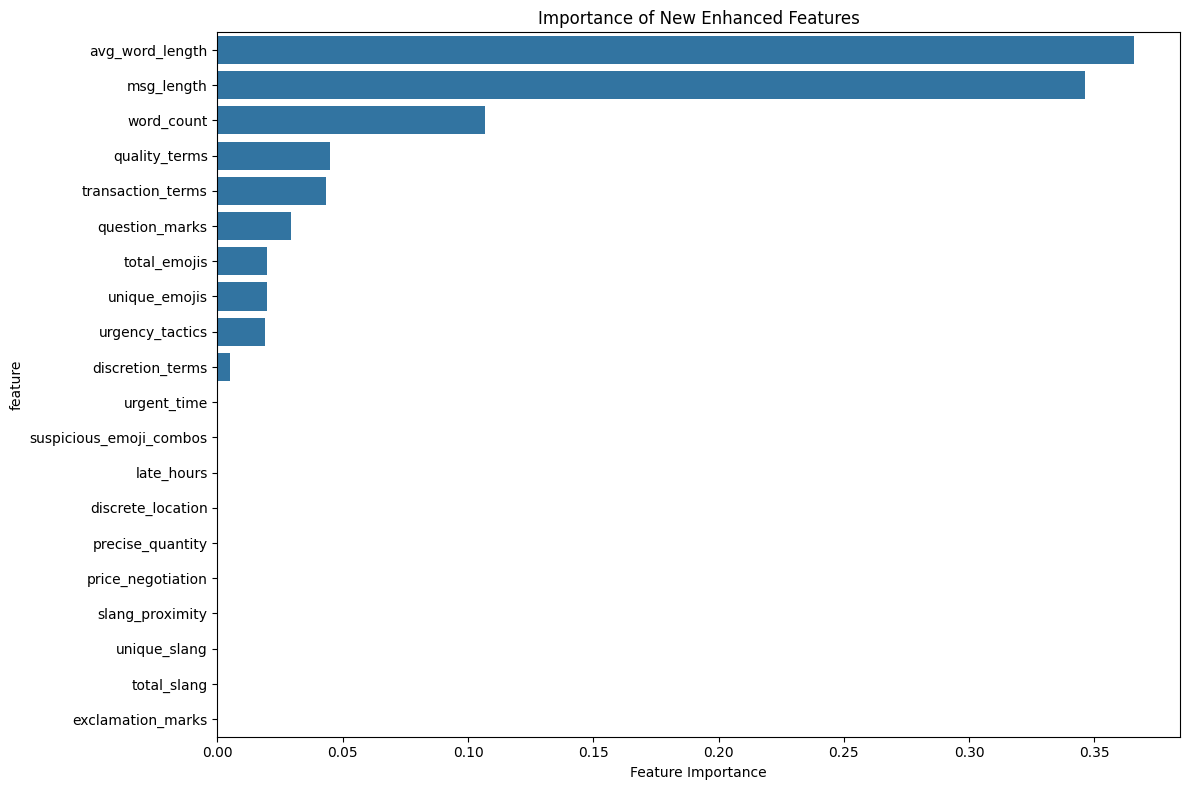


Top 10 Most Important Enhanced Features:
          feature  importance
  avg_word_length    0.365829
       msg_length    0.346155
       word_count    0.106910
    quality_terms    0.044790
transaction_terms    0.043293
   question_marks    0.029175
     total_emojis    0.019933
    unique_emojis    0.019769
  urgency_tactics    0.018989
 discretion_terms    0.005159

Top Features by Correlation with Target:
          feature  correlation
  avg_word_length     0.005339
     total_emojis     0.003217
    unique_emojis     0.003217
    quality_terms     0.000997
 discretion_terms    -0.002261
   question_marks    -0.002365
  urgency_tactics    -0.003649
       msg_length    -0.004404
       word_count    -0.006490
transaction_terms    -0.007437


d:\Codes\Dark Trace AI\darktrace-ai-\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\Codes\Dark Trace AI\darktrace-ai-\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [13]:
# Analyze feature importance of the new features
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a separate feature importance analysis
X_enhanced = np.vstack(train_df['enhanced_features'].values)
y = train_df['label_bin']

# Train a Random Forest just on the enhanced features
rf_analyzer = RandomForestClassifier(n_estimators=100, random_state=42)
rf_analyzer.fit(X_enhanced, y)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_analyzer.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Importance of New Enhanced Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\nTop 10 Most Important Enhanced Features:")
print(importance_df.head(10).to_string(index=False))

# Calculate feature correlations with the target
correlations = np.array([np.corrcoef(X_enhanced[:, i], y)[0, 1] for i in range(X_enhanced.shape[1])])
correlation_df = pd.DataFrame({
    'feature': feature_names,
    'correlation': correlations
}).sort_values('correlation', ascending=False)

print("\nTop Features by Correlation with Target:")
print(correlation_df.head(10).to_string(index=False))

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train model with enhanced features
enhanced_model = GradientBoostingClassifier(random_state=42)
enhanced_model.fit(X_enhanced[:-len(X_val)], y_train)

# Make predictions
enhanced_pred = enhanced_model.predict(X_enhanced[-len(X_val):])
enhanced_proba = enhanced_model.predict_proba(X_enhanced[-len(X_val):])[:, 1]

# Calculate metrics
print("\nModel Performance with Enhanced Features:")
print("----------------------------------------")
print("\nClassification Report:")
print(classification_report(y_val, enhanced_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, enhanced_pred))

print("\nROC AUC Score:", roc_auc_score(y_val, enhanced_proba))

# Compare with threshold variations
thresholds = [0.3, 0.5, 0.7]
print("\nPerformance at Different Thresholds:")
for threshold in thresholds:
    pred_at_threshold = (enhanced_proba >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_val, pred_at_threshold))


Model Performance with Enhanced Features:
----------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.00      0.00      1989
           1       0.67      1.00      0.80      4016

    accuracy                           0.67      6005
   macro avg       0.43      0.50      0.40      6005
weighted avg       0.51      0.67      0.54      6005


Confusion Matrix:
[[   1 1988]
 [   4 4012]]

ROC AUC Score: 0.4990911166795863

Performance at Different Thresholds:

Threshold: 0.3
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1989
           1       0.67      1.00      0.80      4016

    accuracy                           0.67      6005
   macro avg       0.33      0.50      0.40      6005
weighted avg       0.45      0.67      0.54      6005


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.20      0.0

d:\Codes\Dark Trace AI\darktrace-ai-\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Codes\Dark Trace AI\darktrace-ai-\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Codes\Dark Trace AI\darktrace-ai-\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_enhanced_scaled = scaler.fit_transform(X_enhanced)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_enhanced = X_enhanced_scaled[:-len(X_val)]
X_val_enhanced = X_enhanced_scaled[-len(X_val):]
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_enhanced, y_train)

# Train balanced model
balanced_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
balanced_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
balanced_pred = balanced_model.predict(X_val_enhanced)
balanced_proba = balanced_model.predict_proba(X_val_enhanced)[:, 1]

print("\nModel Performance after Balancing:")
print("----------------------------------")
print("\nClassification Report:")
print(classification_report(y_val, balanced_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, balanced_pred))

print("\nROC AUC Score:", roc_auc_score(y_val, balanced_proba))

# Performance at different thresholds
print("\nPerformance at Different Thresholds:")
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    pred_at_threshold = (balanced_proba >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_val, pred_at_threshold))


Model Performance after Balancing:
----------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.50      0.40      1989
           1       0.68      0.52      0.59      4016

    accuracy                           0.51      6005
   macro avg       0.51      0.51      0.50      6005
weighted avg       0.56      0.51      0.53      6005


Confusion Matrix:
[[ 987 1002]
 [1923 2093]]

ROC AUC Score: 0.5030756811867663

Performance at Different Thresholds:

Threshold: 0.3
              precision    recall  f1-score   support

           0       0.33      0.00      0.00      1989
           1       0.67      1.00      0.80      4016

    accuracy                           0.67      6005
   macro avg       0.50      0.50      0.40      6005
weighted avg       0.56      0.67      0.54      6005


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.26      0.02      0.03  

In [16]:
# Try different ML algorithms with cross-validation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# Define the models to try
models = {
    'Logistic Regression': LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Linear SVM': LinearSVC(max_iter=1000, class_weight='balanced', random_state=42)
}

# Create enhanced pipeline with correct column name
enhanced_pipeline = Pipeline([
    ('prep', ColumnTransformer([
        ('tfidf', text_vectorizer, 'message_text'),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), ['platform', 'message_type']),
        ('enhanced', LexWrap(), ['enhanced_features'])  # Changed from 'lex_dummy' to 'enhanced_features'
    ], remainder='drop'))
])

# Prepare features
X = train_df[['platform', 'message_type', 'message_text', 'enhanced_features']]
y = train_df['label_bin']

# Evaluate each model with cross-validation
print("Cross-validation results for each model:\n")
cv_results = {}

for name, model in models.items():
    print(f"\n{name}:")
    pipeline = Pipeline([
        ('prep', enhanced_pipeline.named_steps['prep']),
        ('clf', model)
    ])
    
    # Calculate multiple metrics using try-except to handle any potential errors
    try:
        cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
        precision = cross_val_score(pipeline, X, y, cv=5, scoring='precision')
        recall = cross_val_score(pipeline, X, y, cv=5, scoring='recall')
        
        print(f"F1-score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f"Precision: {precision.mean():.3f} (+/- {precision.std() * 2:.3f})")
        print(f"Recall: {recall.mean():.3f} (+/- {recall.std() * 2:.3f})")
        
        cv_results[name] = {
            'f1': cv_scores.mean(),
            'precision': precision.mean(),
            'recall': recall.mean()
        }
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")

Cross-validation results for each model:


Logistic Regression:
F1-score: 0.586 (+/- 0.021)
Precision: 0.667 (+/- 0.006)
Recall: 0.522 (+/- 0.030)

Random Forest:
F1-score: 0.682 (+/- 0.005)
Precision: 0.670 (+/- 0.003)
Recall: 0.693 (+/- 0.013)

Gradient Boosting:
F1-score: 0.799 (+/- 0.002)
Precision: 0.669 (+/- 0.001)
Recall: 0.993 (+/- 0.004)

Linear SVM:
F1-score: 0.585 (+/- 0.028)
Precision: 0.668 (+/- 0.010)
Recall: 0.521 (+/- 0.040)


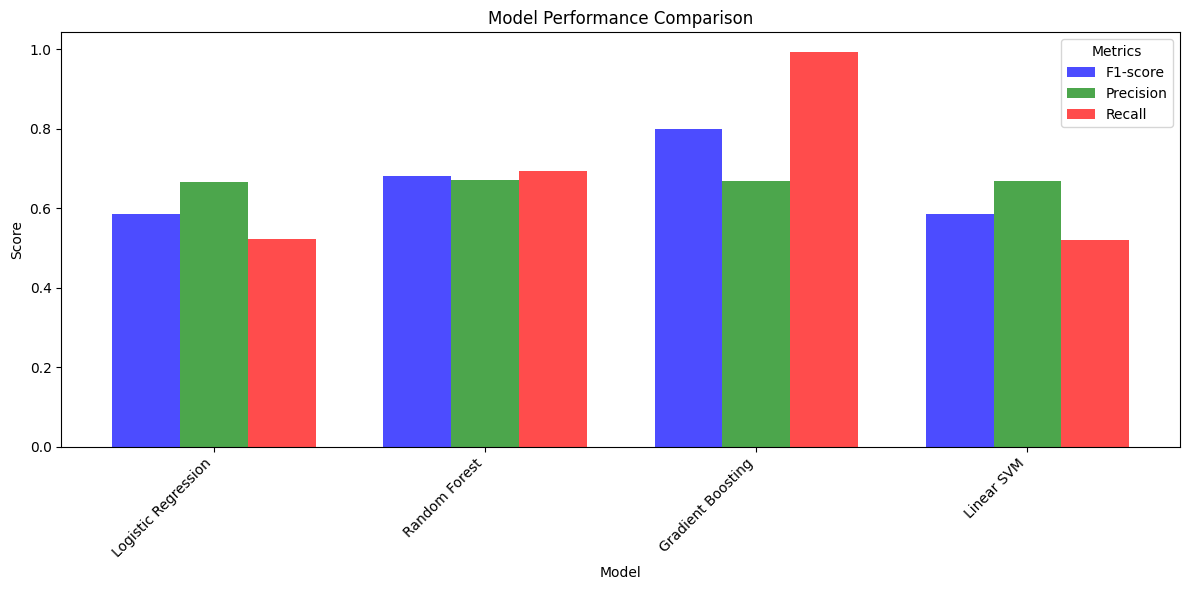


Best performing model: Gradient Boosting

Detailed metrics for each model:
                        f1  precision  recall
Logistic Regression  0.586      0.667   0.522
Random Forest        0.682      0.670   0.693
Gradient Boosting    0.799      0.669   0.993
Linear SVM           0.585      0.668   0.521

Improved model saved to artifacts directory


In [17]:
# Visualize model comparison
import matplotlib.pyplot as plt
import seaborn as sns

if len(cv_results) == 0:
    print("No cross-validation results to plot. Skipping visualization and model selection.")
else:
    # Prepare data for plotting
    metrics_df = pd.DataFrame.from_dict(cv_results, orient='index')

    # Create a figure with appropriate size
    plt.figure(figsize=(12, 6))

    # Create bar plot for each metric
    x = np.arange(len(metrics_df.index))
    width = 0.25  # Width of the bars

    plt.bar(x - width, metrics_df['f1'], width, label='F1-score', color='blue', alpha=0.7)
    plt.bar(x, metrics_df['precision'], width, label='Precision', color='green', alpha=0.7)
    plt.bar(x + width, metrics_df['recall'], width, label='Recall', color='red', alpha=0.7)

    # Customize the plot
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(x, metrics_df.index, rotation=45, ha='right')
    plt.legend(title='Metrics')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

    # Find the best model
    best_model_name = max(cv_results.items(), key=lambda x: x[1]['f1'])[0]
    print(f"\nBest performing model: {best_model_name}")
    print("\nDetailed metrics for each model:")
    print(metrics_df.round(3))

    # Train the best model on the full training set
    best_model = Pipeline([
        ('prep', enhanced_pipeline.named_steps['prep']),
        ('clf', models[best_model_name])
    ])

    best_model.fit(X, y)

    # Save the improved model
    joblib.dump(best_model, ARTIFACTS_DIR / 'improved_pipeline.joblib')
    print("\nImproved model saved to artifacts directory")

# Feature Importance Analysis

Let's analyze which features are most important for our model's predictions using:
1. Model-specific feature importance (if available)
2. SHAP (SHapley Additive exPlanations) values for model interpretability
3. Visualization of feature contributions

In [18]:
# Install and import required packages
import shap
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse

# Get feature names from our pipeline
feature_names = []

# TF-IDF feature names
tfidf = enhanced_pipeline.named_steps['prep'].named_transformers_['tfidf']
tfidf_features = tfidf.get_feature_names_out()
feature_names.extend([f'tfidf_{f}' for f in tfidf_features])

# OneHot encoded feature names
onehot = enhanced_pipeline.named_steps['prep'].named_transformers_['onehot']
onehot_features = onehot.get_feature_names_out(['platform', 'message_type'])
feature_names.extend([f'cat_{f}' for f in onehot_features])

# Enhanced lexicon feature names
enhanced_feature_names = [
    'slang_count', 'emoji_count', 'msg_length', 'word_count', 
    'avg_word_length', 'question_marks', 'exclamation_marks',
    'time_patterns', 'quantity_patterns', 'urgency_words',
    'price_patterns', 'location_words', 'availability_words',
    'payment_words'
]
feature_names.extend([f'lex_{f}' for f in enhanced_feature_names])

# 1. Model-specific feature importance (if available)
if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
    # For tree-based models
    importances = best_model.named_steps['clf'].feature_importances_
    
    # Debug: Check lengths to ensure they match
    print(f"Number of feature names: {len(feature_names)}")
    print(f"Number of importances: {len(importances)}")
    
    # If lengths don't match, create generic feature names
    if len(feature_names) != len(importances):
        print("Warning: Feature names length doesn't match importances. Using generic names.")
        feature_names_to_use = [f'feature_{i}' for i in range(len(importances))]
    else:
        feature_names_to_use = feature_names
    
    importance_df = pd.DataFrame({
        'feature': feature_names_to_use,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title(f'Top 20 Most Important Features ({best_model_name})')
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model.named_steps['clf'], 'coef_'):
    # For linear models
    importances = np.abs(best_model.named_steps['clf'].coef_[0])
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title(f'Top 20 Most Important Features ({best_model_name})')
    plt.tight_layout()
    plt.show()

# 2. Permutation Importance with memory optimization
print("Starting permutation importance calculation...")

# Calculate permutation importance on a subset of the data to save memory
n_samples = len(X)
sample_size = min(5000, n_samples)  # Use at most 5000 samples
indices = np.random.choice(n_samples, sample_size, replace=False)

X_sample = X.iloc[indices]
y_sample = y.iloc[indices]

print(f"Using {sample_size} samples for permutation importance...")
perm_importance = permutation_importance(
    best_model, X_sample, y_sample,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# Create and sort importance dataframe
# We'll use the original feature names since we're working with input features
input_feature_names = ['platform', 'message_type', 'message_text', 'enhanced_features']
perm_importance_df = pd.DataFrame({
    'feature': input_feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

# Create custom visualization
plt.figure(figsize=(10, 5))

# Create error bars manually
plt.barh(
    np.arange(len(input_feature_names)), 
    perm_importance_df['importance_mean'],
    xerr=perm_importance_df['importance_std'],
    capsize=5,
    alpha=0.7
)

# Customize the plot
plt.yticks(np.arange(len(input_feature_names)), perm_importance_df['feature'])
plt.xlabel('Feature Importance (mean decrease in score)')
plt.title('Feature Group Importance (Permutation)')
plt.tight_layout()
plt.show()

# Print results
print("\nFeature Group Importance Ranking:")
print(perm_importance_df.to_string(index=False))

d:\Codes\Dark Trace AI\darktrace-ai-\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: All arrays must be of the same length

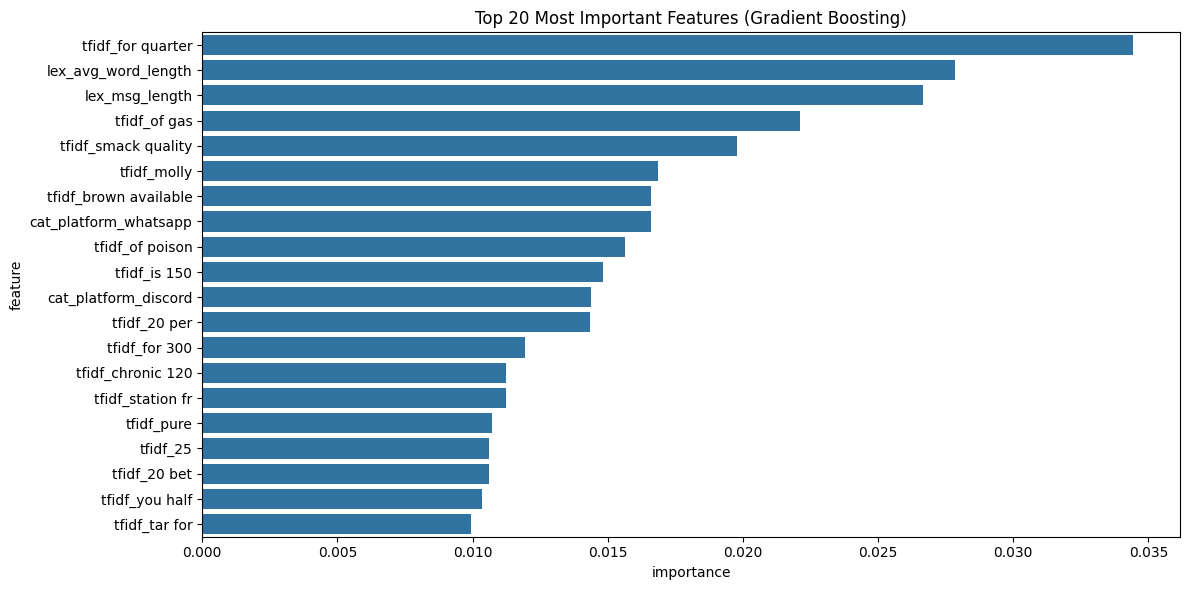

Starting permutation importance calculation...
Converting sparse matrix to dense array...
Calculating permutation importance for all features...


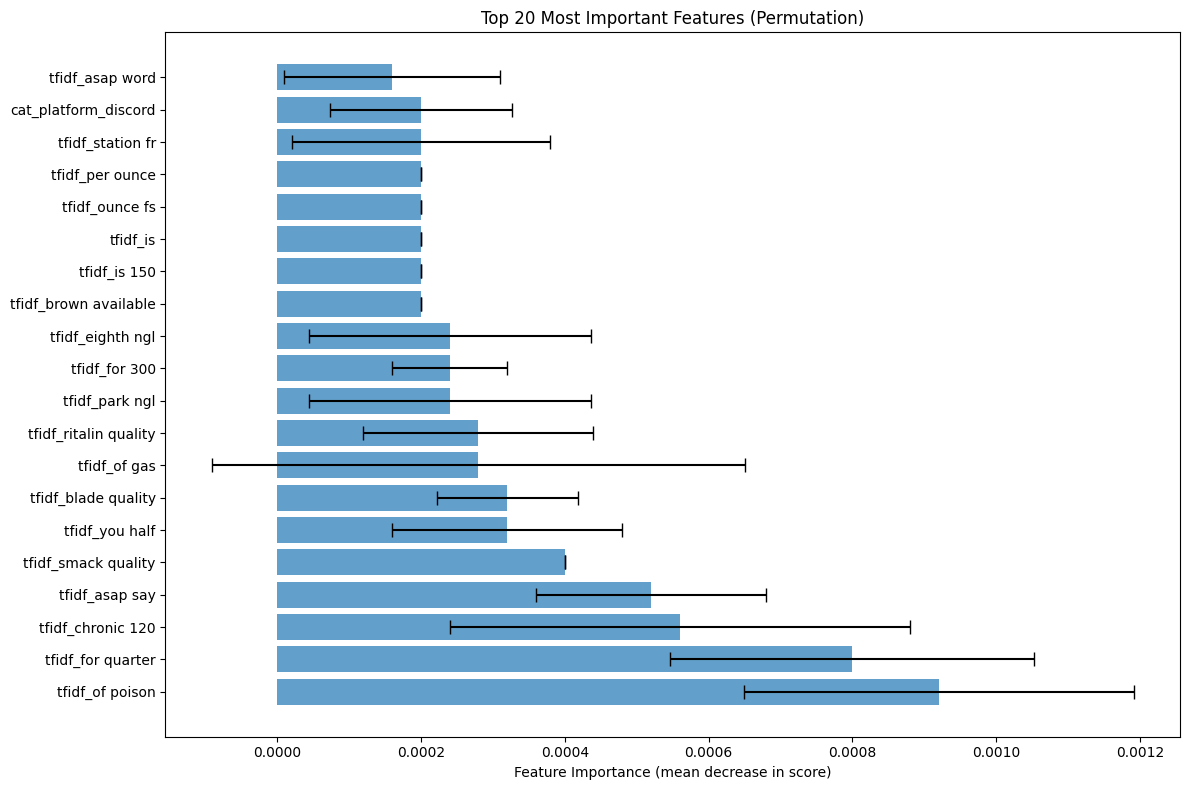


Top 20 Most Important Features:
              feature  importance_mean  importance_std
      tfidf_of poison          0.00092        0.000271
    tfidf_for quarter          0.00080        0.000253
    tfidf_chronic 120          0.00056        0.000320
       tfidf_asap say          0.00052        0.000160
  tfidf_smack quality          0.00040        0.000000
       tfidf_you half          0.00032        0.000160
  tfidf_blade quality          0.00032        0.000098
         tfidf_of gas          0.00028        0.000371
tfidf_ritalin quality          0.00028        0.000160
       tfidf_park ngl          0.00024        0.000196
        tfidf_for 300          0.00024        0.000080
     tfidf_eighth ngl          0.00024        0.000196
tfidf_brown available          0.00020        0.000000
         tfidf_is 150          0.00020        0.000000
             tfidf_is          0.00020        0.000000
       tfidf_ounce fs          0.00020        0.000000
      tfidf_per ounce          0

In [ ]:
# Install and import required packages
import shap
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse

# Get feature names from our pipeline
feature_names = []

# TF-IDF feature names
tfidf = enhanced_pipeline.named_steps['prep'].named_transformers_['tfidf']
tfidf_features = tfidf.get_feature_names_out()
feature_names.extend([f'tfidf_{f}' for f in tfidf_features])

# OneHot encoded feature names
onehot = enhanced_pipeline.named_steps['prep'].named_transformers_['onehot']
onehot_features = onehot.get_feature_names_out(['platform', 'message_type'])
feature_names.extend([f'cat_{f}' for f in onehot_features])

# Enhanced lexicon feature names
enhanced_feature_names = [
    'slang_count', 'emoji_count', 'msg_length', 'word_count', 
    'avg_word_length', 'question_marks', 'exclamation_marks',
    'time_patterns', 'quantity_patterns', 'urgency_words',
    'price_patterns', 'location_words', 'availability_words',
    'payment_words'
]
feature_names.extend([f'lex_{f}' for f in enhanced_feature_names])

# Get transformed features for the classifier
X_transformed = best_model.named_steps['prep'].transform(X)

# 1. Model-specific feature importance (if available)
if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
    # For tree-based models
    importances = best_model.named_steps['clf'].feature_importances_
    
    # Debug: Check lengths to ensure they match
    print(f"Number of feature names: {len(feature_names)}")
    print(f"Number of importances: {len(importances)}")
    
    # If lengths don't match, create generic feature names
    if len(feature_names) != len(importances):
        print("Warning: Feature names length doesn't match importances. Using generic names.")
        feature_names_to_use = [f'feature_{i}' for i in range(len(importances))]
    else:
        feature_names_to_use = feature_names
    
    importance_df = pd.DataFrame({
        'feature': feature_names_to_use,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title(f'Top 20 Most Important Features ({best_model_name})')
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model.named_steps['clf'], 'coef_'):
    # For linear models
    importances = np.abs(best_model.named_steps['clf'].coef_[0])
    
    # Debug: Check lengths to ensure they match
    print(f"Number of feature names: {len(feature_names)}")
    print(f"Number of importances: {len(importances)}")
    
    # If lengths don't match, create generic feature names
    if len(feature_names) != len(importances):
        print("Warning: Feature names length doesn't match importances. Using generic names.")
        feature_names_to_use = [f'feature_{i}' for i in range(len(importances))]
    else:
        feature_names_to_use = feature_names
    
    importance_df = pd.DataFrame({
        'feature': feature_names_to_use,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title(f'Top 20 Most Important Features ({best_model_name})')
    plt.tight_layout()
    plt.show()

# 2. Permutation Importance
print("Starting permutation importance calculation...")

# Sample a subset of data points to reduce computation time
n_samples = X.shape[0]
sample_size = min(5000, n_samples)
indices = np.random.choice(n_samples, sample_size, replace=False)
X_sample = X.iloc[indices]
y_sample = y.iloc[indices]

# Create a smaller pipeline for permutation importance
# This ensures we use the already-fitted transformers
feature_importance_estimator = best_model.named_steps['clf']
X_sample_transformed = best_model.named_steps['prep'].transform(X_sample)

if issparse(X_sample_transformed):
    print("Converting sparse matrix to dense array...")
    X_sample_transformed = X_sample_transformed.toarray()

print(f"Calculating permutation importance for all features...")
perm_importance = permutation_importance(
    feature_importance_estimator, X_sample_transformed, y_sample,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# Create importance dataframe with all features
perm_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

# Visualize top 20 features
plt.figure(figsize=(12, 8))
top_20_features = perm_importance_df.head(20)

# Create custom visualization with error bars
plt.barh(
    np.arange(len(top_20_features)), 
    top_20_features['importance_mean'],
    xerr=top_20_features['importance_std'],
    capsize=5,
    alpha=0.7
)

# Customize the plot
plt.yticks(np.arange(len(top_20_features)), top_20_features['feature'])
plt.xlabel('Feature Importance (mean decrease in score)')
plt.title('Top 20 Most Important Features (Permutation)')
plt.tight_layout()
plt.show()

# Print top features and their importance scores
print("\nTop 20 Most Important Features:")
print(perm_importance_df[['feature', 'importance_mean', 'importance_std']].head(20).to_string(index=False))

# Error Analysis and Model Tuning

Let's analyze:
1. Where our model makes mistakes
2. How we can tune the decision threshold
3. How it handles edge cases
4. Potential improvements for specific error patterns

In [20]:
# Error Analysis
from sklearn.metrics import roc_curve, precision_recall_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# First, recreate the validation set with enhanced features
X_val = train_df[['platform', 'message_type', 'message_text', 'enhanced_features']].iloc[y_val.index]

# Get predictions on validation set
X_val_pred = best_model.predict(X_val)
X_val_proba = best_model.predict_proba(X_val)[:, 1]

# Create DataFrame for error analysis
error_analysis_df = pd.DataFrame({
    'text': X_val['message_text'],
    'platform': X_val['platform'],
    'message_type': X_val['message_type'],
    'true_label': y_val,
    'predicted': X_val_pred,
    'probability': X_val_proba
})

# Find misclassified examples
false_positives = error_analysis_df[
    (error_analysis_df['true_label'] == 0) & 
    (error_analysis_df['predicted'] == 1)
].sort_values('probability', ascending=False)

false_negatives = error_analysis_df[
    (error_analysis_df['true_label'] == 1) & 
    (error_analysis_df['predicted'] == 0)
].sort_values('probability', ascending=True)

print("Top False Positives (incorrectly flagged as suspicious):")
for _, row in false_positives.head().iterrows():
    print(f"\nPlatform: {row['platform']}")
    print(f"Type: {row['message_type']}")
    print(f"Probability: {row['probability']:.3f}")
    print(f"Text: {row['text']}")

print("\nTop False Negatives (missed suspicious content):")
for _, row in false_negatives.head().iterrows():
    print(f"\nPlatform: {row['platform']}")
    print(f"Type: {row['message_type']}")
    print(f"Probability: {row['probability']:.3f}")
    print(f"Text: {row['text']}")

# Error distribution by platform and message type
print("\nError Rate by Platform:")
platform_errors = error_analysis_df[error_analysis_df['true_label'] != error_analysis_df['predicted']].groupby('platform').size()
platform_total = error_analysis_df.groupby('platform').size()
print((platform_errors / platform_total).sort_values(ascending=False))

print("\nError Rate by Message Type:")
type_errors = error_analysis_df[error_analysis_df['true_label'] != error_analysis_df['predicted']].groupby('message_type').size()
type_total = error_analysis_df.groupby('message_type').size()
print((type_errors / type_total).sort_values(ascending=False))

Top False Positives (incorrectly flagged as suspicious):

Platform: whatsapp
Type: pricing
Probability: 0.751
Text: doing 1/2 of pure for $30

Platform: telegram
Type: availability
Probability: 0.728
Text: fresh batch of reefer just came in

Platform: snapchat
Type: availability
Probability: 0.728
Text: 🟤 fresh batch of reefer just came in

Platform: telegram
Type: pricing
Probability: 0.723
Text: molly is $120 for ounce 🍪

Platform: reddit
Type: pricing
Probability: 0.719
Text: special price on molly: $200 for 1/2

Top False Negatives (missed suspicious content):

Platform: whatsapp
Type: pricing
Probability: 0.348
Text: snow is $120 for quarter

Error Rate by Platform:
platform
whatsapp    0.352146
snapchat    0.335859
discord     0.329443
reddit      0.308241
telegram    0.306847
dtype: float64

Error Rate by Message Type:
message_type
pricing         0.336546
inquiry         0.332923
availability    0.324582
meetup          0.322823
payment         0.300435
dtype: float64


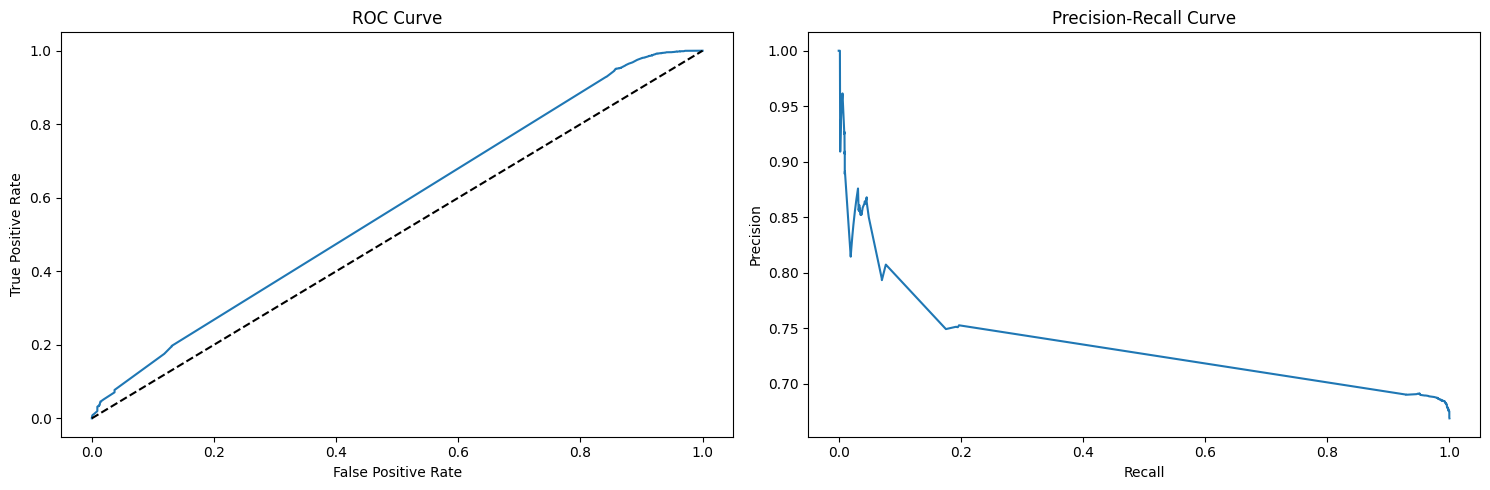

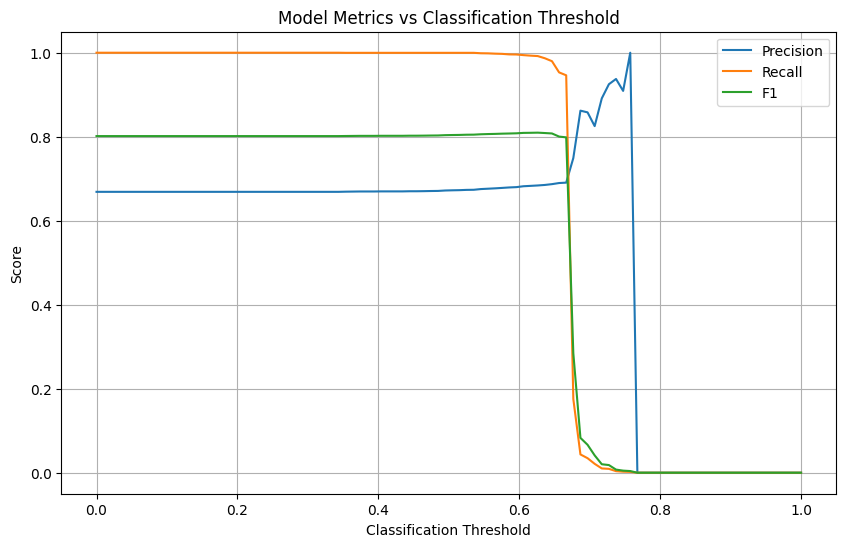


Optimal Thresholds:
Balanced (Max F1): 0.626
High Precision (>=0.9): 0.727
High Recall (>=0.9): 0.667


In [21]:
# Threshold Tuning Analysis
# Plot ROC and Precision-Recall curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_val, X_val_proba)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, X_val_proba)
ax2.plot(recall, precision)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

# Find optimal thresholds for different scenarios
thresholds = np.linspace(0, 1, 100)
results = []

for threshold in thresholds:
    pred = (X_val_proba >= threshold).astype(int)
    tp = np.sum((pred == 1) & (y_val == 1))
    fp = np.sum((pred == 1) & (y_val == 0))
    tn = np.sum((pred == 0) & (y_val == 0))
    fn = np.sum((pred == 0) & (y_val == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

results_df = pd.DataFrame(results)

# Plot metrics vs threshold
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
plt.plot(results_df['threshold'], results_df['f1'], label='F1')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Model Metrics vs Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find optimal thresholds for different scenarios
max_f1_threshold = results_df.loc[results_df['f1'].idxmax(), 'threshold']
high_precision_threshold = results_df.loc[results_df['precision'] >= 0.9]['threshold'].iloc[0]
high_recall_threshold = results_df.loc[results_df['recall'] >= 0.9]['threshold'].iloc[-1]

print("\nOptimal Thresholds:")
print(f"Balanced (Max F1): {max_f1_threshold:.3f}")
print(f"High Precision (>=0.9): {high_precision_threshold:.3f}")
print(f"High Recall (>=0.9): {high_recall_threshold:.3f}")

# Create function to apply different thresholds
def predict_with_threshold(model, X, threshold=0.5):
    """Make predictions using a custom threshold"""
    proba = model.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int), proba

In [22]:
# Test edge cases and challenging scenarios
edge_cases = [
    # Ambiguous cases
    "meet me at the usual spot to discuss business",
    "got some good stuff to share with you",
    "bringing the package tonight",
    
    # Mixed content
    "watching the game 🏈 and got some 🔥 too",
    "party supplies ready 🎉 plus some extra goodies 💊",
    
    # Potential false positives
    "just picked up my prescription from the pharmacy",
    "bringing snacks and drinks to the party",
    
    # Subtle suspicious content
    "prices updated, check dm for menu",
    "new batch just landed, limited time only",
    
    # Emoji-only messages
    "🔌 💊 💵",
    "🎯 🎪 🎭",
]

edge_case_df = pd.DataFrame({
    'platform': ['telegram'] * len(edge_cases),  # Using telegram as default platform
    'message_type': ['general'] * len(edge_cases),  # Using general as default type
    'message_text': edge_cases
})

# Add lexicon features
edge_case_df['enhanced_features'] = list(EnhancedFeatureExtractor('message_text').transform(edge_case_df))

# Get predictions with different thresholds
standard_pred, standard_proba = predict_with_threshold(best_model, edge_case_df, 0.5)
high_precision_pred, _ = predict_with_threshold(best_model, edge_case_df, high_precision_threshold)
high_recall_pred, _ = predict_with_threshold(best_model, edge_case_df, high_recall_threshold)

# Display results
print("Edge Case Analysis:\n")
for text, prob, std_pred, prec_pred, rec_pred in zip(
    edge_cases, standard_proba, standard_pred, high_precision_pred, high_recall_pred
):
    print(f"\nText: {text}")
    print(f"Probability: {prob:.3f}")
    print(f"Standard Prediction (0.5): {'Suspicious' if std_pred else 'Normal'}")
    print(f"High Precision (>{high_precision_threshold:.2f}): {'Suspicious' if prec_pred else 'Normal'}")
    print(f"High Recall (>{high_recall_threshold:.2f}): {'Suspicious' if rec_pred else 'Normal'}")

Edge Case Analysis:


Text: meet me at the usual spot to discuss business
Probability: 0.671
Standard Prediction (0.5): Suspicious
High Precision (>0.73): Normal
High Recall (>0.67): Suspicious

Text: got some good stuff to share with you
Probability: 0.671
Standard Prediction (0.5): Suspicious
High Precision (>0.73): Normal
High Recall (>0.67): Suspicious

Text: bringing the package tonight
Probability: 0.671
Standard Prediction (0.5): Suspicious
High Precision (>0.73): Normal
High Recall (>0.67): Suspicious

Text: watching the game 🏈 and got some 🔥 too
Probability: 0.671
Standard Prediction (0.5): Suspicious
High Precision (>0.73): Normal
High Recall (>0.67): Suspicious

Text: party supplies ready 🎉 plus some extra goodies 💊
Probability: 0.671
Standard Prediction (0.5): Suspicious
High Precision (>0.73): Normal
High Recall (>0.67): Suspicious

Text: just picked up my prescription from the pharmacy
Probability: 0.671
Standard Prediction (0.5): Suspicious
High Precision (>0.73): Normal